In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , FunctionTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [3]:
df_desc = pd.read_csv("data/key.csv", index_col = 0)
df = pd.read_csv("data/data_clean.csv")
df = df.drop("Unnamed: 0",axis=1)

In [4]:
def int_to_object(df):
    df["region_code"] = df["region_code"].astype(object)
    df["district_code"] = df["district_code"].astype(object)
    df["public_meeting"] = df["public_meeting"].astype(str)
    df["permit"] = df["permit"].astype(str)
    df["construction_year_bins"] = df["construction_year_bins"].astype(str)
    return df.dtypes

In [5]:
int_to_object(df)

funder                    object
gps_height                 int64
installer                 object
wpt_name                  object
basin                     object
region_code               object
district_code             object
population                 int64
public_meeting            object
permit                    object
extraction_type_class     object
management                object
payment_type              object
quality_group             object
quantity                  object
source                    object
source_class              object
waterpoint_type           object
status_group              object
construction_year_bins    object
dtype: object

In [6]:
X = df.drop(["status_group"], axis=1)
y = df['status_group']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=465615615)

In [8]:
def grab_numeric(df):
    return df.select_dtypes(include=['int64'])

In [9]:
GrabNumeric = FunctionTransformer(grab_numeric)

In [10]:
pipe= Pipeline(steps=[("num", GrabNumeric),
                      ( "ss", StandardScaler())])

In [11]:
pipe.fit(X_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x000001D3918CE0D0>)),
                ('ss', StandardScaler())])

In [12]:
pipe.transform(X_train)

array([[-0.84040878,  0.25062257],
       [-0.96708423, -0.38007373],
       [ 0.55590018,  0.29266899],
       ...,
       [-0.96708423, -0.38007373],
       [ 0.77614273, -0.37797141],
       [-0.96708423, -0.38007373]])

In [13]:
j = -1
for i in X_train.columns:
    j+=1
    print("Index Number", j,i)

Index Number 0 funder
Index Number 1 gps_height
Index Number 2 installer
Index Number 3 wpt_name
Index Number 4 basin
Index Number 5 region_code
Index Number 6 district_code
Index Number 7 population
Index Number 8 public_meeting
Index Number 9 permit
Index Number 10 extraction_type_class
Index Number 11 management
Index Number 12 payment_type
Index Number 13 quality_group
Index Number 14 quantity
Index Number 15 source
Index Number 16 source_class
Index Number 17 waterpoint_type
Index Number 18 construction_year_bins


In [14]:
# We'll throw these mini-pipelines into our ColumnTransformer.

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer(strategy="median")),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='constant')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [15]:
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [1,7]),
                                         ('subpipe_cat', subpipe_cat, [0,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18])])

In [16]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [17]:
hgb_model_pipe = Pipeline([('ct', CT), ('hgb', HistGradientBoostingClassifier())])

In [18]:
hgb_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [19]:
hgb_model_pipe.score(X_train, y_train)

0.8054096520763188

In [20]:
y_hat = hgb_model_pipe.predict(X_test)
y_hat

array(['functional', 'non functional', 'functional', ..., 'functional',
       'non functional', 'functional'], dtype=object)

In [60]:
print(f"""
Our first model's accuracy on the test set is {accuracy_score(y_test, y_hat)}. \n
Our first model's recall on the test set is {recall_score(y_test, y_hat,average= 'weighted')} \n
Our first model's precision on the test set is {precision_score(y_test, y_hat,average= 'weighted')} \n
Our first model's f1-score on the test is {f1_score(y_test, y_hat,average= 'weighted')}.
""")


Our first model's accuracy on the test set is 0.7818855218855219. 

Our first model's recall on the test set is 0.7818855218855219 

Our first model's precision on the test set is 0.779308701544047 

Our first model's f1-score on the test is 0.767408023787753.



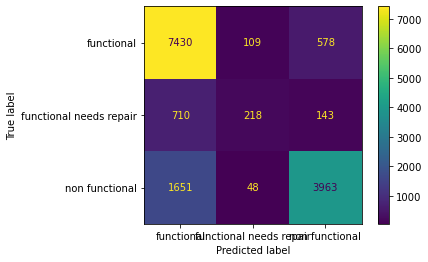

In [22]:
plot_confusion_matrix(hgb_model_pipe, X_test, y_test);

In [23]:
param_grid = {'hgb__learning_rate': [0.1,0.00001],
               'hgb__max_depth': [6,7,8],
               'hgb__min_samples_leaf': [10,12,14,16],}

In [24]:
hgb_grid2 = GridSearchCV(hgb_model_pipe, param_grid=param_grid, n_jobs=-1,cv=5,verbose=2)

In [25]:
hgb_grid2.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [1,
                                                                          7]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                               

In [26]:
# Print the best parameters found
print(hgb_grid2.best_params_)
# Print the best scores found
print(hgb_grid2.best_score_)

{'hgb__learning_rate': 0.1, 'hgb__max_depth': 7, 'hgb__min_samples_leaf': 16}
0.7815937149270482


In [69]:
hgb_model_pipe = Pipeline([('ct', CT), ('hgb', HistGradientBoostingClassifier(max_depth=7, min_samples_leaf=16))])

In [70]:
hgb_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [71]:
y_hat1 = hgb_model_pipe.predict(X_test)

In [72]:
print(f"""
Our first model's accuracy on the test set is {accuracy_score(y_test, y_hat1)}. \n
Our first model's recall on the test set is {recall_score(y_test, y_hat1,average= 'weighted')} \n
Our first model's precision on the test set is {precision_score(y_test, y_hat1,average= 'weighted')} \n
Our first model's f1-score on the test is {f1_score(y_test, y_hat1,average= 'weighted')}.
""")


Our first model's accuracy on the test set is 0.7816161616161617. 

Our first model's recall on the test set is 0.7816161616161617 

Our first model's precision on the test set is 0.7791902214379692 

Our first model's f1-score on the test is 0.7672882918129222.



In [29]:
param_grid = {'hgb__max_depth': [8,9,10,11,12,13,14,15],
               'hgb__min_samples_leaf': [2,3,4,5,6,7,8,9,10],
               "hgb__max_iter" : [5000,10000,15000,20000]}

In [30]:
hgb_grid3 = GridSearchCV(hgb_model_pipe, param_grid=param_grid, n_jobs=-1,cv=5,verbose=3)

In [31]:
hgb_grid3.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 60.0min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 89.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 115.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [1,
                                                                          7]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                               

In [32]:
# Print the best parameters found
print(hgb_grid3.best_params_)
# Print the best scores found
print(hgb_grid3.best_score_)

{'hgb__max_depth': 9, 'hgb__max_iter': 15000, 'hgb__min_samples_leaf': 6}
0.7874074074074074


In [33]:
y_hat3 = hgb_grid3.predict(X_test)

In [64]:
print(f"""
Our first model's accuracy on the test set is {accuracy_score(y_test, y_hat3)}. \n
Our first model's recall on the test set is {recall_score(y_test, y_hat3,average= 'weighted')} \n
Our first model's precision on the test set is {precision_score(y_test, y_hat3,average= 'weighted')} \n
Our first model's f1-score on the test is {f1_score(y_test, y_hat3,average= 'weighted')}.
""")


Our first model's accuracy on the test set is 0.7873400673400673. 

Our first model's recall on the test set is 0.7873400673400673 

Our first model's precision on the test set is 0.7816090619787255 

Our first model's f1-score on the test is 0.7756072306114541.



In [35]:
param_grid = {'hgb__max_depth': [11,12,13,14,15],
               'hgb__min_samples_leaf': [12],
               "hgb__max_iter" : [300, 500,1000]}

In [36]:
hgb_grid4 = GridSearchCV(hgb_model_pipe, param_grid=param_grid, n_jobs=-1,cv=5,verbose=3)

In [37]:
hgb_grid4.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [1,
                                                                          7]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                               

In [38]:
# Print the best parameters found
print(hgb_grid4.best_params_)
# Print the best scores found
print(hgb_grid4.best_score_)

{'hgb__max_depth': 14, 'hgb__max_iter': 500, 'hgb__min_samples_leaf': 12}
0.7871156004489337


In [76]:
hgb_model_pipe = Pipeline([('ct', CT), ('hgb', HistGradientBoostingClassifier(max_depth=14, max_iter=500, min_samples_leaf=12))])

In [77]:
hgb_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [78]:
y_hat4 = hgb_model_pipe.predict(X_test)

In [79]:
print(f"""
Our second model's accuracy on the test set is {accuracy_score(y_test, y_hat4)}. \n
Our second model's recall on the test set is {recall_score(y_test, y_hat4,average= 'weighted')} \n
Our second model's precision on the test set is {precision_score(y_test, y_hat4,average= 'weighted')} \n
Our second model's f1-score on the test is {f1_score(y_test, y_hat4,average= 'weighted')}.
""")


Our second model's accuracy on the test set is 0.7890909090909091. 

Our second model's recall on the test set is 0.7890909090909091 

Our second model's precision on the test set is 0.7841602240827521 

Our second model's f1-score on the test is 0.7785903211053256.



In [41]:
param_grid = {'hgb__max_depth': [14],
               'hgb__min_samples_leaf': [12],
               "hgb__max_iter" : [1000, 1200, 1400, 1600 ]}

In [42]:
hgb_grid5 = GridSearchCV(hgb_model_pipe, param_grid=param_grid, n_jobs=-1,cv=5,verbose=3)

In [43]:
hgb_grid5.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   54.6s remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  1.7min remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [1,
                                                                          7]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                               

In [44]:
# Print the best parameters found
print(hgb_grid5.best_params_)
# Print the best scores found
print(hgb_grid5.best_score_)

{'hgb__max_depth': 14, 'hgb__max_iter': 1400, 'hgb__min_samples_leaf': 12}
0.7862626262626262


In [45]:
y_hat5 = hgb_grid5.predict(X_test)

In [67]:
print(f"""
Our first model's accuracy on the test set is {accuracy_score(y_test, y_hat5)}. \n
Our first model's recall on the test set is {recall_score(y_test, y_hat5,average= 'weighted')} \n
Our first model's precision on the test set is {precision_score(y_test, y_hat5,average= 'weighted')} \n
Our first model's f1-score on the test is {f1_score(y_test, y_hat5,average= 'weighted')}.
""")


Our first model's accuracy on the test set is 0.787946127946128. 

Our first model's recall on the test set is 0.787946127946128 

Our first model's precision on the test set is 0.7838586983536773 

Our first model's f1-score on the test is 0.7762538529844859.



In [47]:
param_grid = {'hgb__max_depth': [14],
               'hgb__min_samples_leaf': [12],
               "hgb__max_iter" : [1600, 2000, 4000, 6000, 8000, 10000, 20000 ]
               }

In [48]:
hgb_grid6 = GridSearchCV(hgb_model_pipe, param_grid=param_grid, n_jobs=-1,cv=5,verbose=3)

In [49]:
hgb_grid6.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:  2.6min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  3.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [1,
                                                                          7]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                               

In [50]:
# Print the best parameters found
print(hgb_grid6.best_params_)
# Print the best scores found
print(hgb_grid6.best_score_)

{'hgb__max_depth': 14, 'hgb__max_iter': 6000, 'hgb__min_samples_leaf': 12}
0.7868686868686869


In [51]:
y_hat5 = hgb_grid5.predict(X_test)

In [68]:
print(f"""
Our first model's accuracy on the test set is {accuracy_score(y_test, y_hat5)}. \n
Our first model's recall on the test set is {recall_score(y_test, y_hat5,average= 'weighted')} \n
Our first model's precision on the test set is {precision_score(y_test, y_hat5,average= 'weighted')} \n
Our first model's f1-score on the test is {f1_score(y_test, y_hat5,average= 'weighted')}.
""")


Our first model's accuracy on the test set is 0.787946127946128. 

Our first model's recall on the test set is 0.787946127946128 

Our first model's precision on the test set is 0.7838586983536773 

Our first model's f1-score on the test is 0.7762538529844859.

